In [1]:
!pip install -q sdv diffprivlib

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sklearn.model_selection import train_test_split

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00


**CARICAMENTO DEL DATASET E SUDDIVISIONE IN TRAIN E HOLDOUT**

In [3]:
def carica_dataset():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    df = pd.read_csv(url, header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato da GitHub")
    return df

#TODO non sono sicura che serva
def preprocessa_dataset(df):
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
    df[cols_missing] = df[cols_missing].replace(0, np.nan)
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())
    return df

df = carica_dataset()
df = preprocessa_dataset(df)

# Suddivide il dataset in train (70%) e holdout (30%)
train_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['outcome'])

# Salva i due dataset in CSV separati
train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Dataset caricato da GitHub
Dimensione train: (537, 9)
Dimensione holdout: (231, 9)


**GENERAZIONE DATI SINTETICI (NO PRIVACY)**

In [4]:
# GENERAZIONE DATI SINTETICI (NO PRIVACY) NOE
def synthetic_no_privacy(df, privacy="none", epsilon=1.0):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    model = CTGANSynthesizer(
      metadata,
      epochs=1500,
      batch_size=250,
      generator_dim=(256, 256, 256),
      discriminator_dim=(256, 256),
      verbose=True
    )
    model.fit(df)
    # Genera dati sintetici
    synthetic= model.sample(num_rows=len(df))
    return synthetic, metadata

synthetic, metadata = synthetic_no_privacy(train_df)
synthetic.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-3.30) | Discrim. (-0.21): 100%|██████████| 1500/1500 [01:25<00:00, 17.52it/s]


**GENERAZIONE DATI SINTETICI (PRIVACY MODERATA E STRONG)** MEGLIO DIVIDERE ANCHE QUESTO?


In [ ]:
#Gio -------

def correggi_valori(df_synth, df_real):
    df_corr = df_synth.copy()

    # Colonne intere
    int_cols = ['age', 'pregnancies', 'outcome']
    for col in int_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].round().astype(int).clip(vmin, vmax)

    # Colonne continue
    cont_cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']
    for col in cont_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].clip(vmin, vmax)

    return df_corr

def add_dp_noise(series, epsilon=1.0):
    sensitivity = series.max() - series.min()
    mech = Laplace(epsilon=epsilon, sensitivity=sensitivity)
    noisy = series.apply(lambda x: mech.randomise(x))
    return noisy

def genera_dataset_sintetico(df_real, privacy_level='moderate'):
    print(f"\nGenerazione dataset sintetico - livello privacy: {privacy_level}")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_real)
    ctgan = CTGANSynthesizer(metadata, epochs=500)
    ctgan.fit(df_real)
    df_synth = ctgan.sample(len(df_real))

    # Rumore DP
    if privacy_level == 'moderate':
        epsilon = 1.0
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)
    elif privacy_level == 'strong':
        epsilon = 0.1
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)

    # Correzione valori fuori range usando dataset reale
    df_synth = correggi_valori(df_synth, df_real)

    return df_synth, metadata

# 2) PRIVACY MODERATA
synthetic_mod, metadata_mod = genera_dataset_sintetico(train_df, privacy_level='moderate')
synthetic_mod.to_csv('dataset/synthetic/synthetic_privacy_moderate.csv', index=False)

# 3) PRIVACY STRONG
synthetic_strong, metadata_strong = genera_dataset_sintetico(train_df, privacy_level='strong')
synthetic_strong.to_csv('dataset/synthetic/synthetic_privacy_strong.csv', index=False)

**VALUTAZIONE SOMIGLIANZA STATISTICA**

In [ ]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )
    print("\n--- Diagnostic report ---")
    # Stampa direttamente l'oggetto diagnostico
    print(diagnostic)

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    # 3) GRAFICO COLONNA (esempio: glucose)
    fig = get_column_plot(
        real_data=real,
        synthetic_data=synth,
        column_name='glucose',
        metadata=metadata
    )
    fig.show()

    return diagnostic, quality_report


In [ ]:
datasets_sintetici = [
    ("NO PRIVACY", synthetic, metadata),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 736.39it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 224.56it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Diagnostic report ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 441.10it/s]|
Column Shapes Score: 82.39%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 191.50it/s]|
Column Pair Trends Score: 89.08%

Overall Score (Average): 85.74%


--- Quality Score ---
0.8573537379129869



===== ANALISI QUALITÀ: PRIVACY MODERATA =====
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 722.05it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 313.73it/s]|
Data Structure Score: 38.46%

Overall Score (Average): 69.23%


--- Diagnostic report ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 289.81it/s]|
Column Shapes Score: 67.52%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 182.19it/s]|
Column Pair Trends Score: 80.67%

Overall Score (Average): 74.09%


--- Quality Score ---
0.7409437658987827



===== ANALISI QUALITÀ: PRIVACY STRONG =====
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 950.28it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 309.29it/s]|
Data Structure Score: 38.46%

Overall Score (Average): 69.23%


--- Diagnostic report ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 222.66it/s]|
Column Shapes Score: 56.08%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 191.15it/s]|
Column Pair Trends Score: 77.0%

Overall Score (Average): 66.54%


--- Quality Score ---
0.6653807569550516


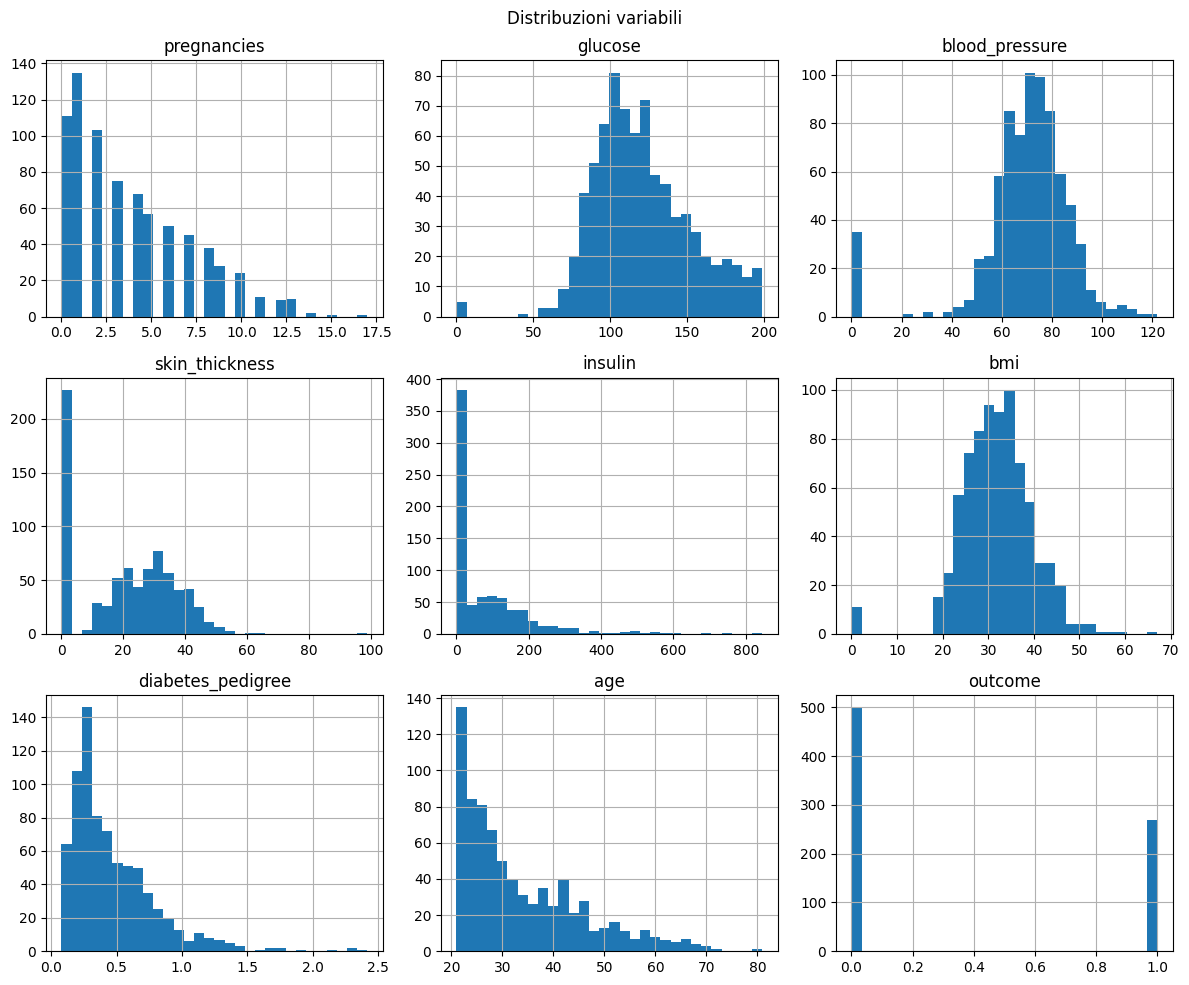

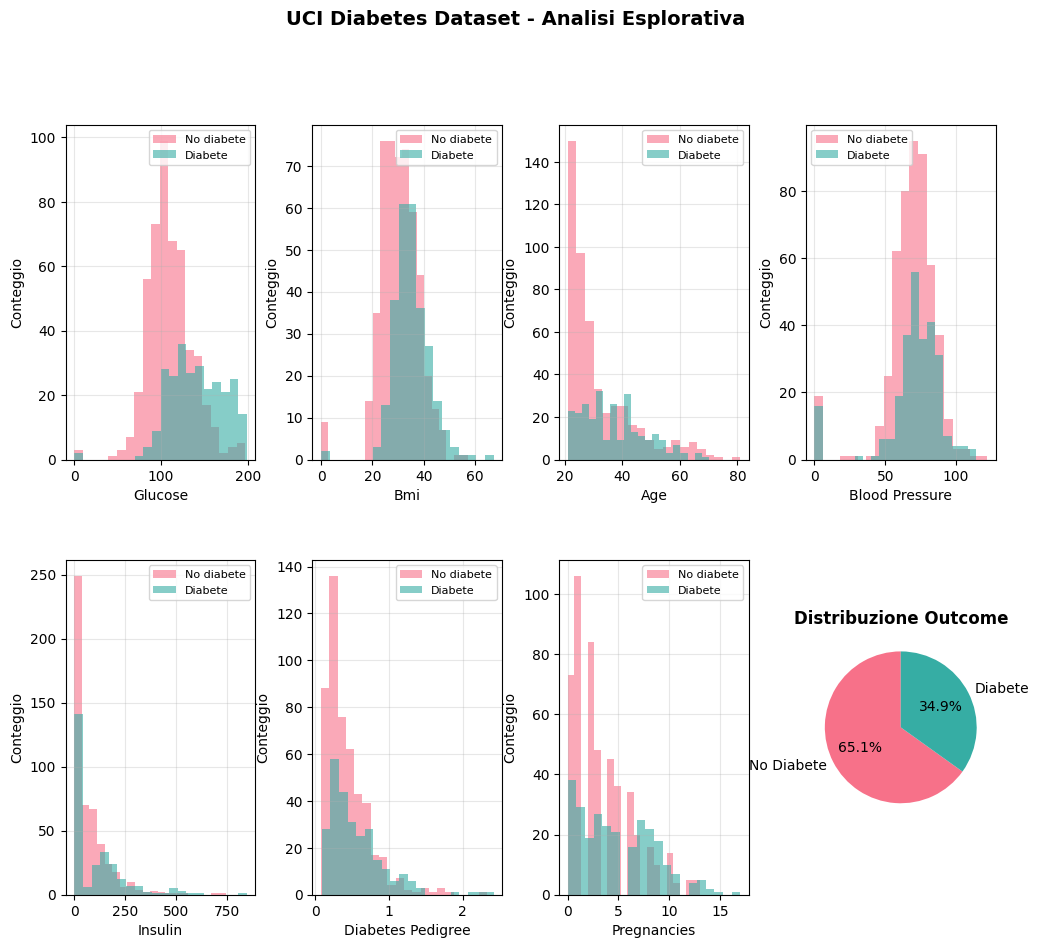

In [ ]:
# GRAFICI:

# Distribuzione delle variabili numeriche
def plot_distributions(df): #Noe
  df.hist(figsize=(12, 10), bins=30)
  plt.suptitle('Distribuzioni variabili')
  plt.tight_layout()
  plt.show()

def plot_distribution2(df): #Gio
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)
    color_palette = sns.color_palette("husl", 2)
    features_plot = ['glucose', 'bmi', 'age', 'blood_pressure', 'insulin', 'diabetes_pedigree', 'pregnancies']

    for i, feature in enumerate(features_plot):
        ax = fig.add_subplot(gs[i//4, i%4])
        df[df['outcome']==0][feature].hist(bins=20, alpha=0.6, color=color_palette[0], label='No diabete', ax=ax)
        df[df['outcome']==1][feature].hist(bins=20, alpha=0.6, color=color_palette[1], label='Diabete', ax=ax)
        ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
        ax.set_ylabel('Conteggio', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    ax = fig.add_subplot(gs[1, 3])
    outcome_counts = df['outcome'].value_counts()
    ax.pie(outcome_counts, labels=['No Diabete', 'Diabete'], autopct='%1.1f%%', colors=color_palette, startangle=90, textprops={'fontsize': 10})
    ax.set_title('Distribuzione Outcome', fontsize=12, fontweight='bold')
    plt.suptitle('UCI Diabetes Dataset - Analisi Esplorativa', fontsize=14, fontweight='bold', y=0.995)
    plt.show()

# Matrice di correlazione
def plot_correlation_matrix(dataset):
  corr = dataset.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr, annot=True, cmap='coolwarm')
  plt.title('Matrice di correlazione')
  plt.show()

plot_distributions(df)
plot_distribution2(df)

**VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout


--- Training su Real Data (Baseline) ---

--- Training su No Privacy ---

--- Training su Moderate Privacy (ε=1.0) ---

--- Training su Strong Privacy (ε=0.1) ---

--- ACCURACY ---
                     Real Data (Baseline)  No Privacy  \
Logistic Regression                 0.745       0.714   
Random Forest                       0.749       0.727   
Gradient Boosting                   0.753       0.714   
XGBoost                             0.753       0.680   
MLP Classifier                      0.723       0.667   
SVM                                 0.753       0.688   

                     Moderate Privacy (ε=1.0)  Strong Privacy (ε=0.1)  
Logistic Regression                     0.649                   0.662  
Random Forest                           0.615                   0.459  
Gradient Boosting                       0.442                   0.420  
XGBoost                                 0.502                   0.511  
MLP Classifier                          0.394             

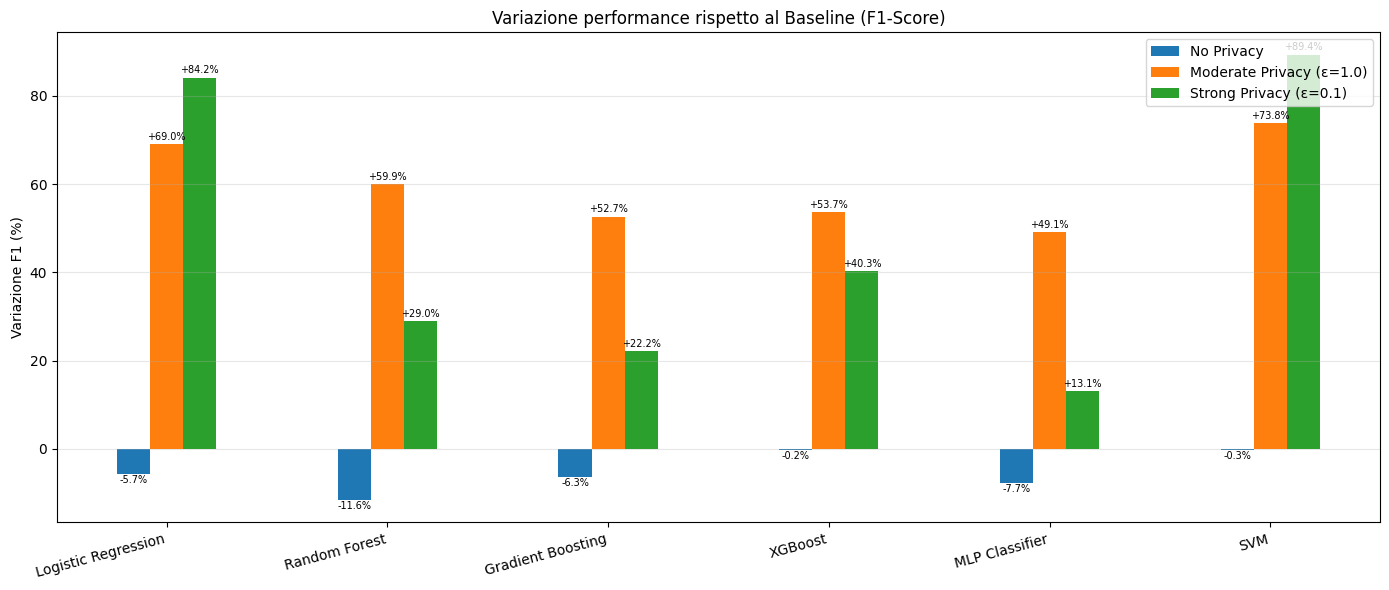


INTERPRETAZIONE DEI RISULTATI

📊 Miglior modello sul baseline: XGBoost
   F1-Score: 0.6174
   ROC-AUC: 0.7906

🔒 Impatto della privacy differenziale:

  Logistic Regression:
    No Privacy: -5.67% di variazione F1-score
    Moderate Privacy (ε=1.0): +69.05% di variazione F1-score
    Strong Privacy (ε=0.1): +84.16% di variazione F1-score

  Random Forest:
    No Privacy: -11.63% di variazione F1-score
    Moderate Privacy (ε=1.0): +59.93% di variazione F1-score
    Strong Privacy (ε=0.1): +29.01% di variazione F1-score

  Gradient Boosting:
    No Privacy: -6.30% di variazione F1-score
    Moderate Privacy (ε=1.0): +52.66% di variazione F1-score
    Strong Privacy (ε=0.1): +22.15% di variazione F1-score

  XGBoost:
    No Privacy: -0.18% di variazione F1-score
    Moderate Privacy (ε=1.0): +53.73% di variazione F1-score
    Strong Privacy (ε=0.1): +40.28% di variazione F1-score

  MLP Classifier:
    No Privacy: -7.74% di variazione F1-score
    Moderate Privacy (ε=1.0): +49.13% di va

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier # Aggiunta: Rete Neurale
import xgboost as xgb # Aggiunta: XGBoost
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------
# FUNZIONE: addestra e valuta modelli su un dataset
# -------------------------------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test):
    # Modelli aggiornati con nuovi algoritmi e ottimizzazione per la robustezza
    models = {
        # Aggiunta regolarizzazione (C=0.5) per robustezza al rumore
        'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        # Riduzione del learning rate (0.08) per un addestramento più stabile sui dati rumorosi
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, random_state=42),
        # Nuovo Modello: Boosting avanzato
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
        # Nuovo Modello: Rete Neurale (utilizza regolarizzazione L2, alpha=0.001)
        'MLP Classifier': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, alpha=0.001, random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }

    results = {}

    # Scalatura applicata a tutti i dati di train/test
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        # I modelli lineari (LR, SVM), e le reti neurali (MLP), beneficiano della scalatura
        if name in ['Logistic Regression', 'SVM', 'MLP Classifier']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            if hasattr(model, 'predict_proba'): # Per modelli che supportano probabilità (LR, MLP, SVM con probability=True)
                y_proba = model.predict_proba(X_test_scaled)[:,1]
            else: # Fallback per SVM se probability non è impostato correttamente o per altre eccezioni
                 y_proba = model.decision_function(X_test_scaled)

        # I modelli ad albero (RF, GB, XGBoost) vengono addestrati senza scalatura
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:,1]

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1_score': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }

    return results

# -------------------------------------------------
# FUNZIONE: valuta modelli su dataset reali e sintetici
# -------------------------------------------------
def evaluate_synthetic_datasets(train_real, holdout, synth_no_priv, synth_mod, synth_strong):
    X_test = holdout.drop('outcome', axis=1)
    y_test = holdout['outcome']

    datasets = {
        'Real Data (Baseline)': train_real,
        'No Privacy': synth_no_priv,
        'Moderate Privacy (ε=1.0)': synth_mod,
        'Strong Privacy (ε=0.1)': synth_strong
    }

    all_results = {}
    for name, df_train in datasets.items():
        print(f"\n--- Training su {name} ---")
        X_train = df_train.drop('outcome', axis=1)
        y_train = df_train['outcome']
        results = train_and_evaluate(X_train, y_train, X_test, y_test)
        all_results[name] = results

    return all_results

# -------------------------------------------------
# FUNZIONE: visualizzazione risultati
# -------------------------------------------------
def plot_results(all_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    baseline = all_results['Real Data (Baseline)']

    # Tabelle metriche
    for metric in metrics:
        df_metric = pd.DataFrame({
            dataset: {model: metrics_dict[metric]
                      for model, metrics_dict in models_dict.items()}
            for dataset, models_dict in all_results.items()
        })
        print(f"\n--- {metric.upper()} ---")
        print(df_metric.round(3))

    # Grafico perdita F1 rispetto al baseline
    models = list(baseline.keys())
    privacy_levels = [k for k in all_results.keys() if k != 'Real Data (Baseline)']

    x = np.arange(len(models))
    width = 0.15 # Adattato la larghezza per i nuovi 6 modelli

    fig, ax = plt.subplots(figsize=(14,6)) # Aumentata la dimensione per i nuovi modelli
    for idx, level in enumerate(privacy_levels):
        drops = [((baseline[m]['f1_score'] - all_results[level][m]['f1_score'])/baseline[m]['f1_score'])*100
                 for m in models]

        # Gestisce i casi in cui i valori F1 siano 0 per evitare divisione per zero nel calcolo della caduta.
        drops = [d if not np.isnan(d) and baseline[models[i]]['f1_score'] != 0 else 100.0 for i, d in enumerate(drops)]

        ax.bar(x + idx*width, drops, width, label=level)
        for i, v in enumerate(drops):
            # Aggiusta la posizione del testo per i valori negativi/positivi
            text_y_pos = v + 0.5 if v >= 0 else v - 2.5
            ax.text(i + idx*width, text_y_pos, f'{v:+.1f}%', ha='center', va='bottom', fontsize=7)

    ax.set_xticks(x + width)
    ax.set_xticklabels(models, rotation=15, ha='right') # Ruota le etichette per leggibilità
    ax.set_ylabel('Variazione F1 (%)')
    ax.set_title('Variazione performance rispetto al Baseline (F1-Score)')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# FUNZIONE: interpretazione risultati
# -------------------------------------------------
def interpret_results(all_results):
    baseline = all_results['Real Data (Baseline)']
    privacy_levels = [k for k in all_results.keys() if k != 'Real Data (Baseline)']

    print("\n" + "="*80)
    print("INTERPRETAZIONE DEI RISULTATI")
    print("="*80)

    # Miglior modello sul baseline
    best_model = max(baseline.items(), key=lambda x: x[1]['f1_score'])
    print(f"\n📊 Miglior modello sul baseline: {best_model[0]}")
    print(f"   F1-Score: {best_model[1]['f1_score']:.4f}")
    print(f"   ROC-AUC: {best_model[1]['roc_auc']:.4f}")

    # Impatto della privacy
    print("\n Impatto della privacy differenziale:")
    all_losses = {}
    for model_name in baseline.keys():
        print(f"\n  {model_name}:")
        all_losses[model_name] = {}
        for level in privacy_levels:
            baseline_f1 = baseline[model_name]['f1_score']
            f1 = all_results[level][model_name]['f1_score']

            # Calcolo della variazione percentuale (gestisce il caso di baseline_f1 = 0)
            if baseline_f1 != 0:
                diff = ((baseline_f1 - f1) / baseline_f1) * 100
            else:
                diff = 100.0 if f1 == 0 else (0.0 - f1) # Perdita massima (100%) se baseline è 0 e f1 è 0, altrimenti variazione assoluta

            all_losses[model_name][level] = diff

            print(f"   {level}: {diff:+.2f}% di variazione F1-score")

    # Raccomandazioni
    for level in ['Moderate Privacy (ε=1.0)', 'Strong Privacy (ε=0.1)']:
        # Calcola la perdita media F1 per il livello di privacy
        losses = [all_losses[m][level] for m in baseline.keys()]
        # Esclude i NaN se presenti (non dovrebbero esserlo dopo la correzione)
        avg_loss = np.mean([l for l in losses if not np.isnan(l)])

        if avg_loss < 10:
            print(f"\n {level}: buon bilanciamento tra utilità e privacy")
            print(f"  Perdita media F1: {avg_loss:.2f}%")
        elif avg_loss < 20:
             print(f"\n {level}: perdita di utilità moderata")
             print(f"  Perdita media F1: {avg_loss:.2f}%")
        else:
            print(f"\n {level}: forte perdita di utilità")
            print(f"  Perdita media F1: {avg_loss:.2f}%")

    # Modello più robusto alla privacy forte
    robustness = {
        model_name: all_losses[model_name]['Strong Privacy (ε=0.1)']
        for model_name in baseline.keys()
    }
    # Il più robusto è quello con la perdita minima (il valore più basso)
    most_robust = min(robustness.items(), key=lambda x: x[1])

    print(f"\n Modello più robusto alla privacy forte: {most_robust[0]}")
    print(f"   Perdita minima F1: {most_robust[1]:.2f}%")
    print("\n" + "="*80)

# -------------------------------------------------
# ESECUZIONE COMPLETA
# -------------------------------------------------
# Supponendo di avere già train_df, holdout_df, synthetic, synthetic_mod, synthetic_strong

results = evaluate_synthetic_datasets(
     train_real=train_df,
     holdout=holdout_df,
   synth_no_priv=synthetic,
    synth_mod=synthetic_mod,
   synth_strong=synthetic_strong
 )

plot_results(results)
interpret_results(results)